In [1]:
## DEMO OUTLINE: Hive, Parquet, Spark SQL, DataFrame
# 000 - Put Flat Files into HDFS and Tail
# 001 - Create HIVE transient tables: explain LOCATION in DDL
# 005 - Create HIVE view: explain purpose of VW
# 010 - Create HIVE parquet table: explain datatype differences
# 015 - Load into parquet table: use beeline to load data into parquet then select 4 columns
# 019 - PySpark data loading 3 ways: HIVE, CSV, Parquet
# 020 - PySpark data access examples: parquet from hive, and pull from cassandra
# 025 - PySpark data wrangling: split-apply-combine, scalar function
# 030 - PySpark save to parquet
# 030 - PySpark save to Cassandra 

# PySpark Demo for Spark, Parquet, Python Talk

## Import Modules

In [1]:
## Magic commands
%matplotlib inline 

## Modules to import
# PySpark automatically creates SparkContext (sc) and SQLContext (sqlCtx)
# SQLContext uses Spark SQL syntax and has no native support to interoperate with existing tables in Hive
# HiveContext let's you query tables/views that already live in Hive having been created outside of Spark
from pyspark import SparkContext, SparkConf # SparkContext is required if you want to sc.stop() and start with diff options
from pyspark.sql import HiveContext, Row # SQLContext is required if you want to query flat files
from pyspark.sql.types import * # Imports all datatypes
from pyspark.sql.functions import * # Functions like sum, min, max, etc
import pandas as pd # Useful for converting to local data frame outside of the grid

In [2]:
## Set SparkContext (sc) variables
sc.appName="PySpark PoC by Doug"

In [3]:
# Spark 1.3.0 (maybe not in Spark 1.4.0), only if you want Spark to speak with CDH 5.4 Hive, you need to set this to false!
# When set to false, Spark SQL will use the Hive SerDe for parquet tables instead of the built in support.
# For more details: https://spark.apache.org/docs/1.3.0/sql-programming-guide.html
# If you don't set this, then you'll get this error below...
#  Py4JJavaError: An error occurred while calling o34.filter.
#  : org.apache.spark.sql.AnalysisException: resolved attributes identifier missing from investment_id,identifier,package_id,asofdate;
sqlCtx.setConf("spark.sql.hive.convertMetastoreParquet", "false")

## Display a list of all tables available in SparkSQL

In [4]:
## Display a list of table names in Hive
# If you install CDH 5.4 there's and option to enable HIVE, whereas if you build from source you need to use HIVE/Yarn flags: 
#  export MAVEN_OPTS="-Xmx2g -XX:MaxPermSize=512M -XX:ReservedCodeCacheSize=512m"
#  mvn -Pyarn -Phadoop-2.5 -Dhadoop.version=2.5.0-cdh5.2.0 -Phive -Phive-thriftserver -DskipTests clean package -X
# Make sure to follow directions in this: https://spark.apache.org/docs/1.3.0/building-spark.html#
# Also refer here for more info about building with Hive:  https://spark.apache.org/docs/latest/sql-programming-guide.html#configuration
# This is all using CD 5.4 (which I'd recommend for a quick start)
sqlCtx.tableNames()

[u'holdings_total_marketvalue',
 u'importdatafullholdingsassetallocation',
 u'importdatafullholdingsbreakdownvalue',
 u'importdatafullholdingscountry',
 u'importdatafullholdingscurrency',
 u'importdatafullholdingsfundshareclass',
 u'importdatafullholdingsholding',
 u'importdatafullholdingsholdingaggregate',
 u'importdatafullholdingsholdingdetail',
 u'importdatafullholdingsholdinglevelflat',
 u'importdatafullholdingsholdinglevelflat_parquet',
 u'importdatafullholdingsholdinglevelflatvw',
 u'importdatafullholdingsinvestmentvehicle',
 u'importdatafullholdingslegaltype',
 u'importdatafullholdingslocalmarketvalue',
 u'importdatafullholdingsoperation',
 u'importdatafullholdingspackagebody',
 u'importdatafullholdingspackageheader',
 u'importdatafullholdingsportfolio',
 u'importdatafullholdingsportfoliobreakdown',
 u'importdatafullholdingsportfoliolist',
 u'importdatafullholdingsportfoliosummary',
 u'importdatafullholdingsshareclassbasics']

## Bind to a HIVE Table

In [5]:
## Bind Spark DataFrame to Hive Table
# A DataFrame is equivalent to a relational table in Spark SQL, and can be created using various functions in SQLContexts
# The following example shows how to construct DataFrames in Python. A similar API is available in Scala and Java.
holdings = sqlCtx.table("importdatafullholdingsholdinglevelflat_parquet") # or importdatafullholdingsholdinglevelflatvw

## Display the first few Row's in the DataFrame

In [6]:
# Prints the first record with data sourced from Hive
# Interesting point: Spark can query HIVE parquet table, and those tiny files in HDFS through EXTERNAL TABLE in HIVE!
# DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.
holdings.first()

Row(dataobjectinstanceversionkey=62903, dataeffectivedt=datetime.datetime(2014, 6, 10, 0, 0), investmentvehicle_id=1, iv_id=u'F000000M03', shareclassbasics_id=1, scb_cusip=u'', scb_ticker=u'', scb_legaltype=u'FO', scb_name=u'DIAM J-REIT Open D1M', operation_id=1, fundshareclass_id=1, fsc_id=u'F000000M03', portfoliolist_id=1, portfolio_id=1, hp_externalid=u'FSUSA0AHAB', currencyid=u'JPY', portfoliosummary_id=1, p_date=datetime.datetime(2014, 1, 16, 0, 0), holding_id=1, holdingdetail_id=1, hd_externalid=u'Mother Fund', hd_id=u'F000002N5J', cusip=u'', isin=u'', sedol=u'', symbol=u'', region=10, sector=u'', country=u'Japan', currency=u'', currencycode=u'', securityname=u'DIAM J-REIT Open Mother Fund', legaltype=u'FO', stylebox=6, marketvalue=120197592000, costbasis=None, maturitydate=None, accruedinterest=None, coupon=None, holdingytdreturn=None, marketcapital=None, localmarketvalue=u'', paymenttype=u'', rule144aeligible=u'', altmintaxeligible=u'', lessthanoneyearbond=u'', firstboughtdate=

## Select specific columns of data

In [7]:
# Let's select 2 of 49 columns and pretty print, using show(), to the screen
# head(), show(), and collect() are all very similar, for this demo we'll use show()
holdings.select("p_date", "iv_id").show()

p_date               iv_id     
2014-01-16 00:00:... F000000M03
2014-01-16 00:00:... F000000M03
2013-12-02 00:00:... F000000MAH
2013-12-02 00:00:... F000000MAH
2014-01-30 00:00:... F000000MK9
2014-01-30 00:00:... F000000MK9
2014-01-27 00:00:... F000000MT7
2014-01-27 00:00:... F000000MT7
2013-12-20 00:00:... F000000MZX
2013-12-20 00:00:... F000000MZX
2013-12-10 00:00:... F000000N51
2013-12-10 00:00:... F000000N51
2014-03-18 00:00:... F000000NA6
2014-03-18 00:00:... F000000NA6
2013-08-12 00:00:... F000000NF4
2013-08-12 00:00:... F000000NF4
2014-03-25 00:00:... F000000NIJ
2014-03-25 00:00:... F000000NIJ
2013-04-01 00:00:... F000000NKW
2013-04-01 00:00:... F000000NKW


## Distinct Operation in Spark DataFrame vs. Pandas DataFrame (Syntax)

In [8]:
# Fetch distinct list of fund id's and pretty print
holdings.select("iv_id").distinct().show()

iv_id     
F00000MA7P
F00000MA81
F00000NAE7
F00000PJPS
F0000027CK
F000001WR1
F000000M88
F000000M7W
F00000PMTL
F00000PHNC
F000000MQQ
F000000MR2
F000005KCR
F00000ITAK
F00000QHB0
F000000NLK
F000000M1I
F0000023DX
F00000MJP8
F00000H6I0


In [9]:
# This would be the equiv of the below in Pandas DataFrame()
frame = holdings.toPandas()
frame.iv_id.unique()

array([u'F000000M03', u'F000000MAH', u'F000000MK9', ..., u'F00000MRA8',
       u'F00000MRAA', u'F00000MSD6'], dtype=object)

## Simple Filter Operation on Spark DataFrame

In [10]:
# *********************** change?
# Bind a Spark DataFrame to the HIVE EXTERNAL transient table consisting of those tiny CSV files in HDFS
# Filter's the DataFrame down by fund id
iv = sqlCtx.table("importdatafullholdingsinvestmentvehicle")
# Using explain() we can see it will perform a HiveTableScan
iv_fund = iv.filter(iv.identifier == "F00000QM1Y")
#iv_fund.explain()
iv_fund.show()

Filter (identifier#51 = F00000QM1Y)
 HiveTableScan [investmentvehicle_id#50,identifier#51,packagebody_id#52,dataeffectivedt#53,dataobjectinstanceversionkey#54L], (MetastoreRelation default, importdatafullholdingsinvestmentvehicle, None), None

investmentvehicle_id identifier packagebody_id dataeffectivedt dataobjectinstanceversionkey
2321                 F00000QM1Y 1              2014-06-10      62903                       


## Compute Total Holdings Per Fund and Holding Period and Sort in Descending Order

In [14]:
# How many holdings are there per fund and holding period 
holdings_group = holdings.groupBy("iv_id", "p_date") # group by: fund, report date, asset class
holdings_group.count().orderBy(desc("count")).show(10)

iv_id      p_date               count
F000000MEI 2013-05-31 00:00:... 3346 
F000000MOM 2013-07-18 00:00:... 2800 
F000000N06 2013-05-27 00:00:... 2764 
F000000M1V 2013-10-15 00:00:... 2168 
F000000NBQ 2013-11-19 00:00:... 1450 
F000000MGJ 2014-03-17 00:00:... 1396 
F000000NPA 2013-09-24 00:00:... 1348 
F000000NHU 2014-03-31 00:00:... 1152 
F000000MVL 2013-11-20 00:00:... 1130 
F000000NJN 2013-05-27 00:00:... 1048 


## Compute Total Market Value using GroupBy and SUM

In [15]:
# computes total market value for each asset class and fund per report date
holdings_group = holdings.filter(holdings.legaltype != "FO")
holdings_group = holdings_group.groupBy("iv_id", "p_date", "legaltype") # group by: fund, report date, asset class
holdings_total_marketvalue = holdings_group.agg({"marketvalue": "sum", "weighting":"sum"}) # compute total market value

# Rename the machine generated label with something that is human readable! May need to rename column again
holdings_total_marketvalue = holdings_total_marketvalue.withColumnRenamed("SUM(marketvalue#34L)", "total_marketvalue")
holdings_total_marketvalue = holdings_total_marketvalue.withColumnRenamed("SUM(weighting#47)", "avg_weighting")

# Display the instruments with the largest market value
holdings_total_marketvalue.orderBy(desc("total_marketvalue")).show(10)

iv_id      p_date               legaltype total_marketvalue avg_weighting
F000000NA0 2014-03-05 00:00:... E         2183281964000     194          
F000000NCI 2014-03-17 00:00:... E         1116702236000     196          
F00000JYL1 2014-03-20 00:00:... EX        1079265568000     196          
F000000MLZ 2013-08-23 00:00:... E         574593122000      184          
F000000MSE 2013-12-13 00:00:... E         469444000000      134          
F000005GEK 2013-10-15 00:00:... EX        455800262000      198          
F00000GVV0 2013-11-20 00:00:... EX        412956422000      198          
F00000MWV3 2014-03-07 00:00:... EX        409420072000      198          
F000000N96 2013-10-15 00:00:... E         303778634000      200          
F000000NHS 2014-01-17 00:00:... BT        300391736000      120          


## Spark DataFrame vs. Pandas DataFrame

In [16]:
# Spark DataFrame: total market value by fund, report date, and asset class of holding position
holdings.groupBy("iv_id", "p_date", "legaltype").agg({"marketvalue": "sum"}).show()

iv_id      p_date               legaltype SUM(marketvalue#34L)
F00000P7R8 2013-09-19 00:00:... C         16597686            
F00000LKJW 2013-09-06 00:00:... FO        593558000           
F000000MQE 2013-07-01 00:00:... FO        23253568000         
F0000022M0 2013-12-24 00:00:... C         6433558             
F00000P05T 2013-09-12 00:00:... FO        3367610000          
F00000LI63 2013-11-15 00:00:... FO        4157758000          
F00000NG8O 2013-12-09 00:00:... EX        562536488           
F00000PV9P 2013-10-15 00:00:... EX        2460992000          
F00000N86T 2013-11-15 00:00:... C         45016               
F00000J7GW 2013-09-20 00:00:... EX        73341738000         
F00000O5F8 2014-02-24 00:00:... FO        284000              
F000000N6G 2013-09-17 00:00:... FO        6471470000          
F00000P05M 2014-02-17 00:00:... FO        66430000            
F00000OS1D 2013-09-09 00:00:... Q         1628191552          
F00000Q7LV 2013-11-21 00:00:... EX        3155333150   

In [17]:
# Spark DataFrame: total market value by fund, report date, and asset class of holding position
frame = holdings.toPandas()
frame.groupby(["iv_id", "p_date", "legaltype"])["marketvalue"].sum().head(15)

iv_id       p_date      legaltype
F000000LVG  2013-08-26  C              176837258
                        EX            8769324000
                        FO             143360000
F000000LVH  2013-06-12  C              700190310
                        FO            8662300000
F000000LVI  2013-12-10  C              574790282
                        EX           41020032000
                        FO             351578000
F000000LVJ  2013-11-25  C              671617626
                        EX           95629058000
                        FO            1064076000
F000000LVK  2013-06-25  C              141420468
                        E              668456000
F000000LVN  2013-12-02  C                1416036
                        FO            2139518000
Name: marketvalue, dtype: int64

## Top Short Positions in Equities

In [20]:
# Top Shorted Equities Per Report Date
holdings_shorts = holdings.filter(holdings.marketvalue < 0) # Short Positions
holdings_shorts = holdings_shorts.filter(holdings.legaltype == "E") # Equities
holdings_shorts = holdings_shorts.groupBy("p_date", "securityname").agg({"marketvalue":"sum", "iv_id":"count"}) # Change to ISIN
holdings_shorts = holdings_shorts.withColumnRenamed("SUM(marketvalue#34L)", "total_marketvalue") # Rename
holdings_shorts.orderBy(asc("total_marketvalue")).show(30) # Pretty Print

p_date               securityname         total_marketvalue COUNT(iv_id#3)
2013-07-16 00:00:... Eisai                -24882000         2             
2013-07-16 00:00:... Sumitomo Corp.       -23914000         2             
2013-07-16 00:00:... Marubeni Corporation -20132000         2             
2013-07-16 00:00:... Shiseido Company,... -18414000         2             
2013-07-16 00:00:... Kao Corporation      -17250000         2             
2013-07-16 00:00:... Shin-Etsu Chemica... -16776000         2             
2013-07-16 00:00:... Unicharm Corp        -16500000         2             
2013-07-16 00:00:... Itochu Corp.         -16354000         2             
2013-07-16 00:00:... SECOM Co., Ltd.      -15932000         2             
2013-11-27 00:00:... Japan Steel Works    -15092000         2             
2013-07-16 00:00:... Kagome Co., Ltd.     -14598000         2             
2013-07-16 00:00:... Seven & i Holding... -14274000         2             
2013-07-16 00:00:... Cano

## Save DataFrame as HIVE Table

In [24]:
# Saves DataFrame as HIVE table stored in Parquet format, specificies to overwrite the dataset 
# see and show screenshot of "hadoop fs -ls /user/hive/warehouse/holdings_total_marketvalue"
# NOTE: Saving tables (or even Parquet Files) with DecimalType(20,2) is not supported in Spark 1.3.0, so you need to cast it
# NOTE: Can't access this data via beeline/hive client tools at this time, version change?
holdings_total_marketvalue_example = holdings_total_marketvalue.select(
    holdings_total_marketvalue.iv_id,
    holdings_total_marketvalue.p_date,
    holdings_total_marketvalue.legaltype,
    holdings_total_marketvalue.total_marketvalue.cast("int").alias('total_marketvalue')
)
# holdings_total_marketvalue_string.show(5)

# Saves as a table back to Hive
# NOTE: querying hive table, using beeline, results in failure below (probably need right jar for source)
holdings_total_marketvalue_example.saveAsTable("holdings_total_marketvalue", source="parquet", mode="overwrite")
# Loads table back from Hive into DataFrame
holdings_total_marketvalue_example = sqlCtx.table("holdings_total_marketvalue")
# Shows first few records
holdings_total_marketvalue_example.show(3)

iv_id      p_date               legaltype total_marketvalue
F00000P7R8 2013-09-19 00:00:... C         16597686         
F00000ODIM 2014-04-14 00:00:... C         7617346          
F0000022M0 2013-12-24 00:00:... C         6433558          


## Save DataFrame as Parquet File

In [113]:
# Saves dataset as Parquet file on local disk and preserves the schema
# holdings_total_marketvalue.saveAsParquetFile("/tmp/holdings_total_marketvalue.parquet")
holdings_total_marketvalue_string.saveAsParquetFile("/tmp/holdings_total_marketvalue.parquet")

## Load from Parquet File into DataFrame

In [25]:
# Loads Parquet dataset into Spark Data Frame
holdings_total_marketvalue_from_file = sqlCtx.parquetFile("/tmp/holdings_total_marketvalue.parquet")
holdings_total_marketvalue_from_file.show(10)

iv_id      p_date               legaltype total_marketvalue_string
F00000P7R8 2013-09-19 00:00:... C         8298843                 
F00000ODIM 2014-04-14 00:00:... C         3808673                 
F0000022M0 2013-12-24 00:00:... C         3216779                 
F000005O45 2014-01-17 00:00:... EX        4753398                 
F00000NG8O 2013-12-09 00:00:... EX        281268244               
F00000PV9P 2013-10-15 00:00:... EX        1230496000              
F00000N86T 2013-11-15 00:00:... C         22508                   
F00000J7GW 2013-09-20 00:00:... EX        36670869000             
F000001WY6 2014-01-15 00:00:... C         5250115                 
F000001WVS 2014-01-20 00:00:... C         8516975                 


## Loading from Raw Structured Data File in Local FS

In [26]:
# Load a text file and convert each line to a tuple.
csv = sc.textFile("file:///home/yoda/Documents/HoldingsFlat.csv")
fields = csv.map(lambda l: l.split("|"))
header = "iv_id|p_date|cusip|sedol|isin|securityname|marketvalue|weighting"
data = fields.map(lambda p: [p[x] for x in range(len(header.split("|")))])

# All columns are string, not strongly-typed
fields = [StructField(field_name, StringType(), True) for field_name in header.split("|")]
schema = StructType(fields)

# Apply the schema to the RDD.
schemaData = sqlCtx.createDataFrame(data, schema)

# Register the DataFrame as a table.
schemaData.registerTempTable("holdings")

# SQL can be run over DataFrames that have been registered as a table.
results = sqlCtx.sql("SELECT * FROM holdings limit 2")

# Display results
results.show()

iv_id      p_date              cusip sedol isin securityname         marketvalue weighting
F000000LVG 2013-08-26 00:00:00                  Cash & Cash Equiv... 88418629    2        
F000000LVG 2013-08-26 00:00:00                  Fullerton VPIC Fu... 4384662000  96       


In [15]:
frame.head(10)

,iv_id,p_date,legaltype,total_marketvalue,avg_weighting
0,F00000P7R8,2013-09-19,C,8298843,0
1,F00000ODIM,2014-04-14,C,3808673,1
2,F0000022M0,2013-12-24,C,3216779,1
3,F000005O45,2014-01-17,EX,4753398,1
4,F00000NG8O,2013-12-09,EX,281268244,98
5,F00000PV9P,2013-10-15,EX,1230496000,97
6,F00000N86T,2013-11-15,C,22508,2
7,F00000J7GW,2013-09-20,EX,36670869000,99
8,F000001WY6,2014-01-15,C,5250115,2
9,F000001WVS,2014-01-20,C,8516975,0


## Convert to Local Pandas DataFrame and Visualize

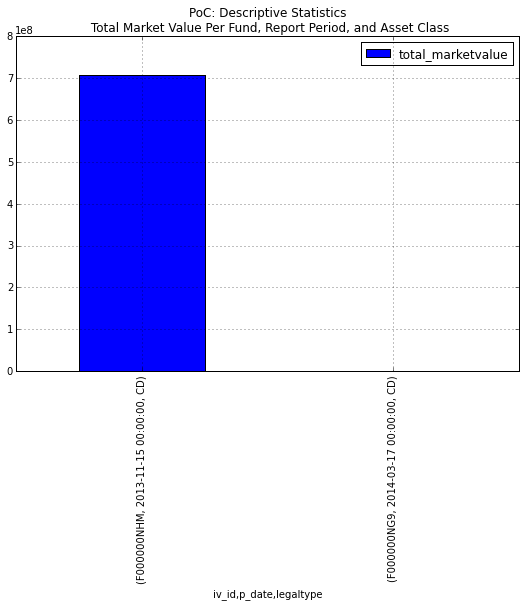

In [25]:
# Subset the frame by asset class and reindex it to prep for plotting
frame_asset = frame[frame["legaltype"] == "CD"] # Credit Default
frame_asset = frame_asset.set_index(["iv_id", "p_date", "legaltype"])

# Plot: all data features in a bar chart layout
title = "PoC: Descriptive Statistics \n Total Market Value Per Fund, Report Period, and Asset Class"
size = (9, 6)
ax = frame_asset.plot(kind='bar', stacked=True, figsize=size, title=title)

## Register DataFrame as SparkSQL Table for SQL-like Queries

In [26]:
# Registers the DataFrame (SchemaRDD) as a SparkSQL Temporary Table
holdings.registerTempTable("holdings")

# Executes same query over temp table
sqlCtx.sql("""
select iv_id, p_date, legaltype, sum(marketvalue) as total_marketvalue 
from holdings 
group by iv_id, p_date, legaltype
limit 10
""").show()

iv_id      p_date               legaltype total_marketvalue
F00000P7R8 2013-09-19 00:00:... C         8298843          
F00000LKJW 2013-09-06 00:00:... FO        296779000        
F000000MQE 2013-07-01 00:00:... FO        11626784000      
F0000022M0 2013-12-24 00:00:... C         3216779          
F00000P05T 2013-09-12 00:00:... FO        1683805000       
F00000LI63 2013-11-15 00:00:... FO        2078879000       
F00000NG8O 2013-12-09 00:00:... EX        281268244        
F00000PV9P 2013-10-15 00:00:... EX        1230496000       
F00000N86T 2013-11-15 00:00:... C         22508            
F00000J7GW 2013-09-20 00:00:... EX        36670869000      


## Push Python Function into Spark as SQL UDF

In [27]:
# Create a Python UDF and push that into Spark to be executed
# Consider how hard this is to do currently in SQL Server or Oracle!
def long_short_code(marketvalue):
    if marketvalue >= 0:
        code = "L"
    elif marketvalue <0:
        code = "S"
    else:
        code = "NA"
    return code

# Registers a lambda function as a UDF so it can be used in SQL statements, return type by default is string
sqlCtx.registerFunction("long_short_code", long_short_code)
holdings_ls = sqlCtx.sql("select *, long_short_code('marketvalue') as long_short_code from holdings limit 10")
holdings_ls.select("p_date", "iv_id", "long_short_code", "sedol", "marketvalue").show(2)

p_date               iv_id      long_short_code sedol marketvalue 
2014-01-16 00:00:... F000000M03 L                     120197592000
2014-01-16 00:00:... F000000M03 L                     31748543    


## Import Data From Cassandra into PySpark

In [35]:
import pyspark_cassandra # pyspark cassandra module created by me
# Mapping to Cassandra
# Takes a keyspace (database) and table and returns a cassandraRDD which operates similar to a regular RDD
holdings = sc.cassandraTable("morningstar", "fullholdingsholdinglevelflat")
# Fetch the first record in the Cassandra table and return it
holdings.first()
# Fetch single fund all holdings all report periods
filtered = holdings.filter(lambda row: row.iv_id=="F000000N8Q")
filtered.take(1)

[Row(accruedinterest=None, altmintaxeligible=u'', costbasis=None, country=u'', coupon=None, currency=u'', currencycode=u'', currencyid=u'JPY', cusip=u'J01554104', dataeffectivedt=datetime.datetime(2014, 6, 10, 0, 0), dataobjectinstanceversionkey=62903, firstboughtdate=None, fsc_id=u'F000000N8Q', fundshareclass_id=1600, hd_externalid=u'', hd_id=u'E0JPN002TS', holding_id=1588, holdingdetail_id=29160, holdingytdreturn=Decimal('1'), hp_externalid=u'FSUSA08JKY', investmentvehicle_id=1600, isin=u'', iv_id=u'F000000N8Q', legaltype=u'E', lessthanoneyearbond=u'', localmarketvalue=u'', marketcapital=None, marketvalue=0, maturitydate=None, numberofshare=0, operation_id=1600, p_date=datetime.datetime(2014, 2, 24, 0, 0), paymenttype=u'', portfolio_id=1588, portfoliolist_id=1588, portfoliosummary_id=1588, region=10, rule144aeligible=u'', scb_cusip=u'', scb_legaltype=u'FO', scb_name=u'MHAM Newly Growth Stk Op', scb_ticker=u'', sector=u'', securityname=u'Anritsu Corp', sedol=u'B020T55', sharechange=-1

## Resources

In [2]:
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
# 